#### Completing a Master of Science in Analytics from NC State's Institute for Advanced Analytics provides a wealth of knowledge and grants access to an extensive network of successful alumni, including data scientists, analysts, and engineers. Throughout the Summer and Fall semesters, conversations with alumni have unveiled several intriguing career paths. My interest in the pre-processing steps of data analysis led me to initiate informational interviews with data engineers, seeking insight and advice while taking notes.

#### After completing my text analytics class, I realized the potential of the dataset I had generated, prompting me to reconnect with alumni. Six of them graciously permitted me to incorporate the notes from our discussions into a project. The analysis revealed three distinct clusters of conversation notes or documents and identified three topics using Latent Dirichlet Allocation (LDA). Furthermore, conducting sentiment analysis indicated consistently mid-high valence (positivity) across all documents, with a mean score of 5.99 on a scale of 1-9.

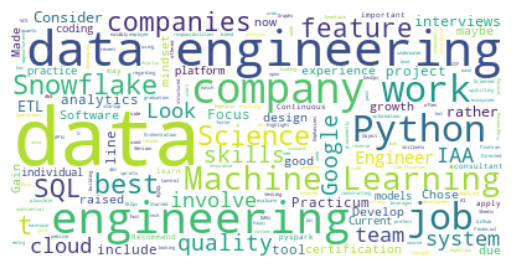

In [29]:
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("data.csv") # Load data
text = " ".join(doc for doc in data.notes)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

I've received permission to use 6 documents of anonymized data from IAA alumni, I'll read in that data and do some EDA

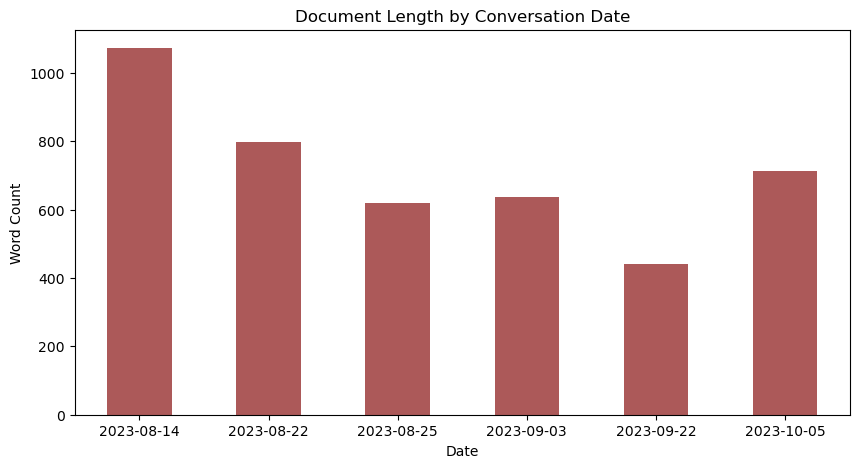

In [30]:
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
np.random.seed(10)

data = pd.read_csv("data.csv") # Load data

# Aside from the notes themselves, another attribute in the data is the date of the conversation. 
# Maybe there's an association between the sentiment of the review and the date of the conversation.
doc_length = []
for i in data.index:
    doc_length.append(len(data.loc[i, 'notes'])) # adds a column for the note length
    
data['doc length'] = doc_length # appends column to the dataframe

data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y') # Converts date column type to datetime 
data['date'] = data['date'].dt.date # drops the times

plot_df = data.drop('id', axis = 1)
plot_df.set_index('date').sort_index().plot.bar(rot=0, figsize=(10, 5), alpha=0.65, color ='maroon')
plt.legend('', frameon=False)
plt.title('Document Length by Conversation Date')
plt.xlabel("Date")
plt.ylabel("Word Count")
plt.show() # Other than the document length, there isn't too much of interest, I'll move on to processing.


#### The typical document length is around 400-800 words. I'll now move on to the analytics. 

I'll need to create a similarity matrix to understand the similarity between documents. I chose to do this using word embeddings. Word embeddings are numeric vectors assigned to individual words. Words closer to each other in the "embedding space" are considered more similar. I used spaCy's medium natural language processing (NLP) model, which was trained on web text. I created initial NLP models for each document and then removed stop words ("and," "the," etc...) and punctuation. I then computed the 6x6 similarity matrix and found the documents were quite similar, with the largest discrepancy between documents 4 and 5.

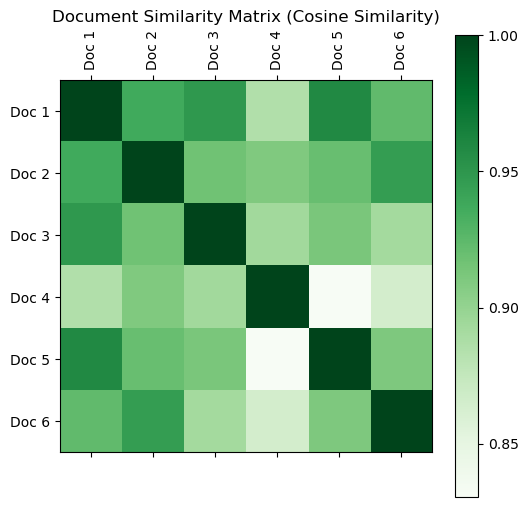

In [31]:
nlp = spacy.load('en_core_web_md')  # Loads model

doc = list(data['notes']) # Isolating the documents


# Create initial NLP models of full document text

doc_nlp = []
for d in doc:
    doc_nlp.append(nlp(d))

# Strip punctuation, numbers, stop words

doc_strip = []
for i, d_nlp in enumerate(doc_nlp):
    doc_strip.append([tok.text for tok in d_nlp if (tok.is_alpha & (not tok.is_stop))])
    doc_strip[-1] = ' '.join(doc_strip[-1])

# Re-compute NLP on stripped documents

doc_strip_nlp = []
for d in doc_strip:
    doc_strip_nlp.append(nlp(d))

# Build similarity matrix

sim_mat = np.diag([1.0] * len(doc_strip_nlp))
for i in range(0, len(doc_strip_nlp) - 1):
    for j in range(i + 1, len(doc_strip_nlp)):
        sim_mat[i][j] = doc_strip_nlp[i].similarity(doc_strip_nlp[j])
        sim_mat[j][i] = sim_mat[i][j]

# Unsuprisingly, the documents are quite similar to eachother. 
labels = ["Doc 1", "Doc 2", "Doc 3", "Doc 4", "Doc 5", "Doc 6"]

fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(sim_mat, interpolation='nearest', cmap = "Greens")
ax.grid(False)
plt.title('Document Similarity Matrix (Cosine Similarity)')
plt.xticks(range(6), labels, rotation=90);
plt.yticks(range(6), labels);
fig.colorbar(cax, ticks=[.85,.90,.95,1])
plt.show()

#### With the Similarity matrix, I can move on to clustering. I chose to go with K-Means clustering

I reduced the similarity matrix to 2 dimensions using principal component analysis (PCA) to improve visualization. I then created an elbow plot to determine an appropriate k for clustering. I decided to go with 3 clusters, and after comparing the clustering results with the similarity matrix, I found the dimensional reduction preserved the relationships well. As observed in the similarity matrix, document 4 is the most dissimilar from the rest and ends up in a cluster of its own. 

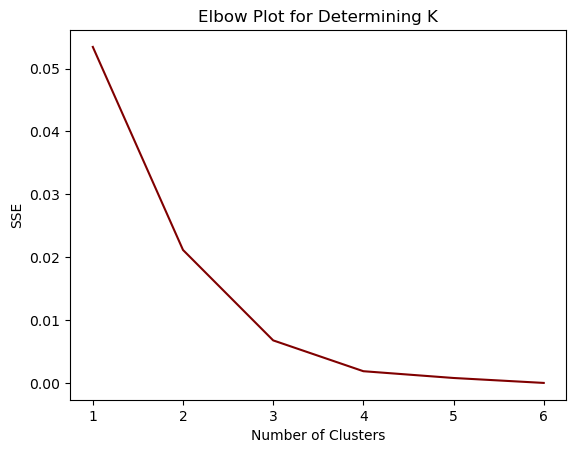

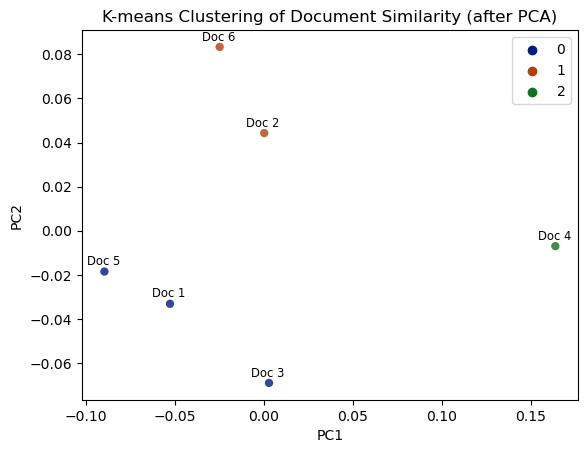

In [32]:
# PCA and K Means clustering
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sim_mat) # PCA of similarity matrix
embeddings_df = pd.DataFrame({"x":embeddings_2d[:, 0], "y":embeddings_2d[:, 1]})
#fig = px.scatter(embeddings_df, x='PC1', y='PC2', opacity=0.5)
#fig.show()

# Elbow plot
sse = {}
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, max_iter=100, n_init=10).fit(embeddings_2d)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color= 'maroon')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Elbow Plot for Determining K')
plt.show() # a K of 3 seems appropriate 

# Creates clusters
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(embeddings_2d)


doc_labels =  ["Doc 1", "Doc 2", "Doc 3", "Doc 4", "Doc 5", "Doc 6"]

#plt.scatter(embeddings_2d[:,0],embeddings_2d[:,1], c=kmeans.labels_, cmap="rainbow")
p = sns.scatterplot(data=embeddings_2d, x=embeddings_2d[:,0],y=embeddings_2d[:,1],
                hue=kmeans.labels_, palette= "dark", alpha = .8, linewidth=0, edgecolor="none")

for line in range(0, len(doc_labels)):
    p.text(embeddings_2d[line][0] - 0.01, embeddings_2d[line][1] + 0.003, 
    doc_labels[line], horizontalalignment='left', 
    size='small', color='black')
#data = embeddings_2d
data["clusters"] = kmeans.labels_
labels = kmeans.labels_
plt.title('K-means Clustering of Document Similarity (after PCA)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# storing cluster info in the dataframe
data["cluster"] = kmeans.labels_

#### There are three distinct clusters. I'll perform topic analysis to understand what causes these clusters to separate

Like with K-means clustering, topic modeling through LDA has a level of arbitrariness. In this case, k also must be chosen, but k is the number of topics you'd like to identify. Due to the small sample size and the fact that there are 3 document clusters, I chose to model 3 topics as well. LDA operates under the assumption that documents sharing similar topics contain similar sets of words, treating documents as probability distributions across latent topics. This means that each document has one topic with the highest probability. The top 5 words for each topic are listed below, and each topic has a similar but slightly different theme. Topic 0 focuses on technology, including Python, SQL, and Snowflake. In contrast, Topic 1 comprises data science methodologies, with a particular emphasis on machine learning. Topic 2, while somewhat diverse, revolves more around the broader spectrum of work life.

In [33]:
topic_list = []
topic_weight_list = []

def display_doc_2_topic(doc_2_topic, document):
    """ 
    This function accepts the document topic distribution [obtained from the lda.transform() method] and the documents of interest.
    It creates a list of topics (topic_list) for each document, indicating the highest probability topic.
    """
    for i in range(0, len(document)):
        topic_wt = list(doc_2_topic[i])
        idx = topic_wt.index(max(topic_wt))
        topic_list.append(idx)
        topic_weight_list.append(topic_wt[ idx ])

def display_topics(model, feat_nm, top_word_n):
    """ 
    This function accepts a lda model, the number of features (words) we'd like to consider in our weight calculation, 
    and finally, the top_n words of a topic we'd like to view. It displays The top_n words that make up a topic and their
    normalized weight 

    """
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        topic_len = sum(topic)

        term = " ".join(
            [
                f"{feat_nm[i]} ({topic[i] / topic_len * 100.0:.02f}%); "
                for i in topic.argsort()[: -top_word_n - 1 : -1]
            ]
        )
        print("   " + term)

feat_n = 10 # 10 words per topic

#  Raw term counts for LDA


tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=1, max_features=feat_n, stop_words="english"
)
tf = tf_vectorizer.fit_transform(doc)
tf_feat_nm = tf_vectorizer.get_feature_names_out()

topic_n = 3 # 3 topics

lda = LatentDirichletAllocation(
    n_components=topic_n,
    max_iter=50,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

lda_topic = lda.fit(tf)
doc_2_topic = lda.transform(tf)

top_word_n = 5 # print top 5 words from topics

display_topics(lda, tf_feat_nm, top_word_n)

# creates the list of topics and their weight for each entry
display_doc_2_topic(doc_2_topic, doc)

data["topic"] = topic_list

Topic 0:
   python (18.76%);  company (15.14%);  sql (12.98%);  best (12.91%);  snowflake (12.86%); 
Topic 1:
   machine (25.94%);  learning (25.90%);  company (15.11%);  science (10.00%);  companies (9.92%); 
Topic 2:
   companies (10.39%);  best (10.32%);  work (10.15%);  snowflake (10.02%);  python (9.98%); 


| Document | Cluster | Topic |
| --- | --- | --- |
| 1 | 0 | 0 |
| 2 | 1 | 1 |
| 3 | 0 | 0 |
| 4 | 2 | 1 |
| 5 | 0 | 0 |
| 6 | 1 | 0 |


The clusters separate partially according to topics; for instance, cluster 0 exclusively comprises documents with the highest probability for topic 0. However, this pattern does not hold for the remaining three documents, as their highest probability topics are a blend of topics 0 and 1. This analysis reveals that my discussions primarily centered around the technology and statistical techniques alumni employed rather than delving into their general work life (topic 2). In the future, I plan to inquire more about this specific topic to gain a more comprehensive perspective of their experiences. 

#### Finally, I assessed the valence of each document and explored any potential associations between valence and clusters. I saw no substantial difference in valence among documents and found all of them had a moderate to high valence of around 6 on a scale from 1 to 9.

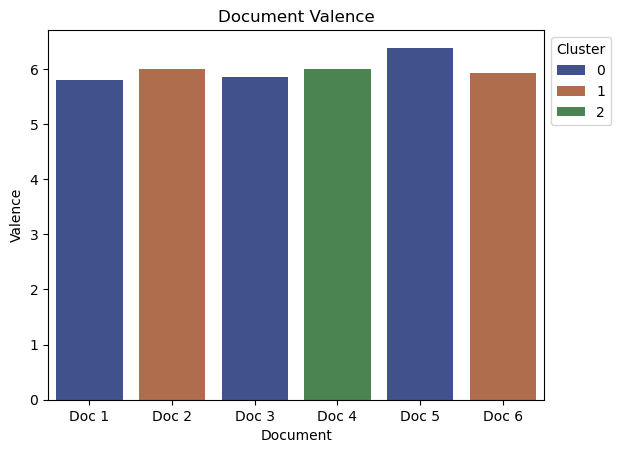

In [34]:
from sentiment_module import sentiment 

valence_list = []
for i in range(6):
    doc = (data["notes"][i]).split()
    valence_list.append(sentiment.valence(doc))
    
data["valence"] = valence_list

plot_df = data[[ "cluster", "valence", "date"]]

plot_df['id'] =  ["Doc 1", "Doc 2", "Doc 3", "Doc 4", "Doc 5", "Doc 6"]


p = sns.barplot(data=plot_df, x="id", y="valence",
                hue="cluster", palette= "dark", alpha = .8, dodge = False)
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1), title='Cluster')
plt.xlabel("Document")
plt.ylabel("Valence")
plt.title('Document Valence')
plt.show() 

#### This analysis indicates that the documents share more similarities than differences. The minor differences, however, have provided valuable perspectives on the types of questions I pose and the information I prioritize in my notes. The LDA topic analysis revealed a noticeable inclination towards technology and statistics, prompting me to consider a more comprehensive approach in future informational interviews. Moving forward, I plan to ask broader questions to understand alumni's post-IAA work experiences more holistically.

#### While acknowledging the limitations of the small sample size in this analysis, I am pleased to have established this framework. I'm excited to apply it to future conversation notes from subsequent informational interviews. The examination of six documents proved insightful, and expanding the dataset will enhance the depth of insights I can glean.